# Down Quilt Baffle Analysis

Baffles in down quilts are typically specified by a baffle height and width. This creates a rectangular baffle. However, when stuffed with down, that rectangle is no longer the largest cross sectional shape. The perimeter of the baffle is fixed - fabric doesn't have musch stretch in it once sewn - however, the cross sectional area can change, and if there is an generally outward force, as from down inside the baffle, the baffle shape will change such that the area is maximized. 

For a baffle in the middle of a quilt, the baffle edges are fixed. By symmetry, the must be straight edges, as there are baffles on either side. However, the top and bottom of the baffle can bend, and do so in response to a pressure exerted on those faces by the down fill. We want to find how much the top and bottom sides bend, and how this changes the necessary down fill volume and thermal properties of the baffle.

## Rectangular Baffle

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
import functools

import tqdm

def catenary(a, x):
    return a*np.cosh((x)/a)

def catenary_area_under(a, x0):
    return 2*a*np.sinh(x0/a)

catenary_arc_length = catenary_area_under

def catenary_x0(a, W):
    return a*np.arcsinh(W/(2*a))

def baffle_width(W, H):
    a = opt_a(W, H)
    return 2*catenary_x0(a, W)[0]

def catenary_area_inside(a, W):
    x0 = catenary_x0(a, W)
    return 2*x0*(catenary(a,x0) - (a-1)) - W

def rect_baffle_area(a, W, H):
    x0 = catenary_x0(a, W)
    return 2*catenary_area_inside(a, W) + 2*x0*H

def neg_rect_baffle_area(a, W, H):
    return -1*rect_baffle_area(a, W, H)

def catenary_y_off(a, W):
    x0 = catenary_x0(a, W)
    return catenary(a, x0) - a

def opt_a(W, H):
    return minimize(neg_rect_baffle_area, 2, args=(W,H)).x

Expected baffle width: 5.00, Actual baffle width: 4.32, difference: -13.62%
Expected baffle height: 2.50, peak baffle height: 4.71, average baffle height: 4.40
Expected baffle area: 12.50, Actual baffle area: 18.99, difference: 51.95%


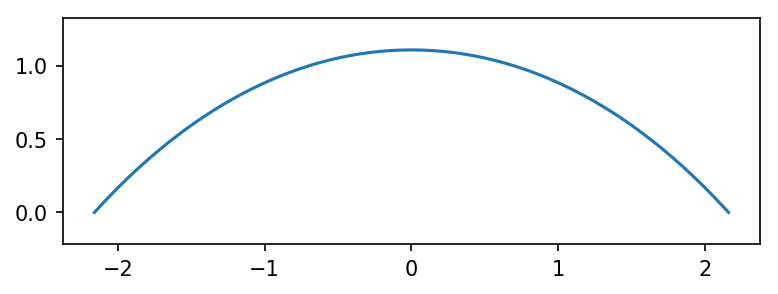

In [2]:
W = 5
H = 2.5
a = opt_a(W, H)
x0 = catenary_x0(a, W)[0]
x = np.linspace(-x0, x0, 101)
y = -catenary(a, x) + catenary_y_off(a, W) + a

area = rect_baffle_area(a, W, H)[0]
avg_baffle_height = area/(2*x0)
print(f"Expected baffle width: {W:.2f}, Actual baffle width: {(2*x0):.2f}, difference: {((2*x0-W)/W*100):.2f}%")
print(f"Expected baffle height: {H:.2f}, peak baffle height: {(H+2*catenary_y_off(a, W)[0]):.2f}, "
      f"average baffle height: {avg_baffle_height:.2f}")
print(f"Expected baffle area: {(W*H):.2f}, Actual baffle area: {area:.2f}, difference: {((area-W*H)/(W*H)*100):.2f}%")

fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=150)
ax.axis('equal')
plt.plot(x, y)
#plt.plot([-x0, x0], [(avg_baffle_height-3)/2]*2, 'r-')
plt.show()

In [3]:
def plot_baffle(L, H):
    a = opt_a(L, H)
    x0 = catenary_x0(a, L)[0]
    x = np.linspace(-x0, x0, 101)
    top = -catenary(a, x) + catenary_y_off(a, L) + a + H/2
    bottom = -top
    vertices = list(zip(x,top))+list(zip(np.flip(x, 0),bottom))
    return plt.Polygon(vertices, facecolor=None, fill=False)

# Thermal resistance and mass efficiency

We are adding parallel thermal resistors:

$$\frac{1}{R} = \sum_i \frac{1}{R_i}$$
$$R_i = k\frac{h}{w}$$

where $h$ is the height of the baffle at location $i$, $w$ is the width of a resistive segment, and $k$ is the resistivity.

$$\frac{1}{R_i} = \frac{1}{k}\frac{w}{h}$$
$$\frac{1}{R} = \frac{1}{k}\int\frac{dw}{h(w)}$$
$$R = k \bigg( \int\frac{dw}{h(w)} \bigg)^{-1}$$

Since the resistance, $R_i$ is porportional to the height of the baffle, the integral of the resistances is the area:

$$A = \int h(w) dw$$

The insulating efficiency is then

$$\epsilon = \frac{R}{kA} = \bigg( \int\frac{1}{h(w)}dw \int h(w) dw \bigg)^{-1}$$

If $h(w)$ is constant, $h(w)=h_0$, then:

$$\epsilon = \bigg( \frac{w}{h_0} w h_0 \bigg)^{-1} = \frac{1}{w^2}$$

we have an extra factor of $w^2$, which is throwing us off from unit efficiency. huh. This makes sense, as in my 2d picture, $k$ has units of Ohms, so $\epsilon$ should have units of inverse area. How do I go about getting rid of this?



We are going to look at this in three dimensions. Our figure of merit is the thermal resistance per unit mass

$$R_{ij} = k \frac{h}{\Delta w \Delta l}$$

$$\frac{1}{R_{ij}} = \frac{\Delta w \Delta l}{k h}$$

$$\frac{1}{R} = \sum_i \sum_j \frac{1}{R_{ij}} = \frac{1}{k}\int\int \frac{1}{h(w,l)}dw dl$$

$$R_A = Ak\bigg(\int\int \frac{1}{h(w,l)}dw dl\bigg)^{-1}$$

$$M = \rho \int \int h(w, l) dw dl$$

$$M_A = \frac{\rho}{A} \int \int h(w, l) dw dl$$

$$\epsilon = \frac{R}{M} = \frac{k}{\rho} \bigg( \int\int \frac{1}{h(w,l)}dw dl \int \int h(w, l) dw dl \bigg)^{-1}$$

$$\epsilon_A = \frac{R_A}{M_A} = A^2 \epsilon = \frac{k A^2}{\rho} \bigg( \int\int \frac{1}{h(w,l)}dw dl \int \int h(w, l) dw dl \bigg)^{-1}$$

Now if we set $h(w,l)=h_0$:

$$\epsilon = \frac{k}{\rho} \frac{1}{(wl)^2} = \frac{k}{\rho} \frac{1}{A^2}$$

$[k] = \Omega m$, $[\rho] = \frac{kg}{m^3}$ which implies that $[\epsilon] = \frac{\Omega}{kg}$, just as we wanted. So the units work out, but this result still seems a little odd. As the base area increases with a constant height, the efficiency decreases. Aha! This makes sense. As the area increases, the mass increases linearly with the area, and the resistance decreases linearly with area. Therefore, the efficiency decreases quadratically with area. Okay. This means that what we really want is the resistance per unit area, and the volume per unit area. Beign a little more precise:

$$\epsilon = \frac{k}{\rho} \bigg( \int\int \frac{1}{h(w,l)}dw dl \int \int h(w, l) dw dl \bigg)^{-1}$$

$$\epsilon = \frac{k}{\rho} \bigg( \int_{-\frac{l_0}{2}}^{\frac{l_0}{2}}\int_{-\frac{w_0}{2}}^{\frac{w_0}{2}} \frac{1}{h(w,l)}dw dl \int_{-\frac{l_0}{2}}^{\frac{l_0}{2}} \int_{-\frac{w_0}{2}}^{\frac{w_0}{2}} h(w, l) dw dl \bigg)^{-1}$$

$$\epsilon = \frac{k}{\rho} \frac{1}{(w_0 l_0)^2} = \frac{k}{\rho} \frac{1}{A_0^2}$$

$$\epsilon_A = \frac{k}{\rho}$$

We can try this definition on a less efficient baffle design:

$$ h(w,l)=   \left\{
\begin{array}{ll}
      h_0 & w<0 \\
      2h_0 & w>=0 \\
\end{array} 
\right.  $$

$$R_A = Ak \bigg( \frac{1}{h_0}\int_{-\frac{l_0}{2}}^{\frac{l_0}{2}} \int_{-\frac{w_0}{2}}^{0} dwdl + \frac{1}{2h_0}\int^{\frac{l_0}{2}}_{-\frac{l_0}{2}} \int^{\frac{w_0}{2}}_{0} dwdl \bigg)^{-1}$$

$$R_A = Ak \bigg( \frac{w_0l_0}{2h_0} + \frac{w_0l_0}{4h_0} \bigg)^{-1}$$

$$R_A = \frac{4}{3}k h_0 $$

$$M_A = \frac{\rho}{A} \int \int h(w, l) dw dl = \frac{\rho}{A} \int_{-\frac{l_0}{2}}^{\frac{l_0}{2}} 
\bigg( h_0\int_{-\frac{w_0}{2}}^{0} dw + 2h_0\int^{\frac{w_0}{2}}_{0} dw \bigg) = \frac{3}{2} \rho h_0$$

$$\epsilon_A = \frac{R_A}{M_A} = \frac{8}{9} \frac{k}{\rho}$$

Which is, indeed, lower than the default value! This gives me some confidence in what we are doing here. We can redefine the these 3d equations for 2 dimensions:

$$R_w = w_0k\bigg(\int\frac{1}{h(w)}dw\bigg)^{-1}$$

$$M_w = \frac{\rho}{w_0} \int h(w) dw$$

As well as define a relative efficiency:

$$\epsilon_r = \frac{\rho}{k} \epsilon_w = w_0^2 \bigg(\int\frac{1}{h(w)}dw \int h(w) dw \bigg)^{-1}$$

Since we know that ideal efficiency will be $k/\rho$. Now we can define some functions to perform these marvelous calculations:

We can rewrite the mass and resistance equations to account for the extra mass added by the face fabric and baffle separation material. The thermal resistance doesnt change, as the thickness of the fabric is approximately zero. The mass changes by gaining an additional term for two faces and one baffle side (the other baffle side belongs to the neighboring baffle. The edges don't quite work, but it's a small failure in the approximation).

$$R_w = w_0k\bigg(\int\frac{1}{h(w)}dw\bigg)^{-1}$$

$$M_w = \frac{1}{w_0} \bigg( \rho \int h(w) dw + 2 \lambda_{face} w_0 + \lambda_{baffle} h_0\bigg)$$

Where $\lambda$ is the linear mass density of the fabric, $\rho$ is the (area?) density of the down, and $k$ is the (area?) thermal conductivity of the down. We will need to convert from the proper area and volume densities to linear and area densities, respectively. 

The absolute efficiency is then calculated as:

$$\epsilon = \frac{R_w}{M_w} = kw_0^2 \bigg[ \bigg( \int\frac{1}{h(w)}dw \bigg) \bigg( \rho \int h(w) dw + 2 \lambda_{face} w_0 + \lambda_{baffle} h_0 \bigg) \bigg]^{-1}$$

And the relative efficiency is:

$$\epsilon_r = \frac{\epsilon_{real}}{\epsilon_{ideal}}$$

Where $\epsilon_{real}$ is the efficiency of the baffle once accounting for distortion due to down filling, and $\epsilon_{ideal}$ is the efficiency of a baffle that is assumed to be perfectly rectangular. We can calculate a more closed form for $\epsilon_{ideal}$:

$$\epsilon_{ideal}=kw_0^2 \frac{h_0}{w_0} \bigg( \rho w_0 h_0 + 2 \lambda_{face} w_0 + \lambda_{baffle} h_0 \bigg)^{-1}$$

$$\epsilon_{ideal}=k\bigg( \rho+2 \frac{\lambda_{face}}{h_0} + \frac{\lambda_{baffle}}{w_0} \bigg)^{-1}$$

Importantly, it is no longer easy to factor out all of the constant to come up with an absolutely relative number. Additionally, the relative magnitudes of $\rho$ and the $\lambda$'s are important. We can't just set all the constants equal to one. While we can still cancel $k$ out in a relative efficiency, we need to find real world values for the densities. Thankfully, $k$ is the constant that is hardest to lock down a number on. The densities are for down and fabric are commonly measured and reported. We just need to do a little conversion.

Down density, $\rho$ is reported in $\frac{in^3}{oz}$, and we want it in $\frac{oz}{in^2}$. To convert, we will assume that the baffle is one inch long, and then invert:

$$\frac{oz}{in^2}=\bigg(\frac{in^3}{oz}\bigg)^{-1}in$$

Fabric density, $\lambda$ is reported in $\frac{oz}{yd^2}$, and we want it in $\frac{oz}{in}$. To convert we go through a similar process, without the inversion.

$$\frac{oz}{in} = \frac{oz}{yd^2}\frac{yd^2}{(36 in)^2}in$$

In [2]:
def convert_down_density(rho_imperial):
    return 1/(rho_imperial)

def convert_fabric_density(lambda_imperial):
    return lambda_imperial/36**2

print(convert_down_density(800))
print(convert_fabric_density(1.3))

0.00125
0.0010030864197530865


In [1]:
def baffle_height(x, L, H):
    a = opt_a(L, H)[0]
    return H + 2*(-catenary(a, x) + catenary_y_off(a, L) + a)

def inv_baffle_height(x, L, H):
        return 1/baffle_height(x, L, H)
    

def relative_efficiency(L, H):
    a = opt_a(L, H)[0]
    x0 = catenary_x0(a, L)
    w0 = 2*x0
    def thermal_res_width_normed():
        return w0*1/(quad(inv_baffle_height, -x0, x0, args=(L, H))[0])
    def mass_width_normed():
        return 1/w0 * quad(baffle_height, -x0, x0, args=(L, H))[0]
    return thermal_res_width_normed()/mass_width_normed()

In [5]:
wide = np.linspace(0.1, 10, 100)
heights = [.05, 0.5, 1, 2, 3, 4]
dat = []
for h in heights:
    dat.append([relative_efficiency(w, h) for w in wide])

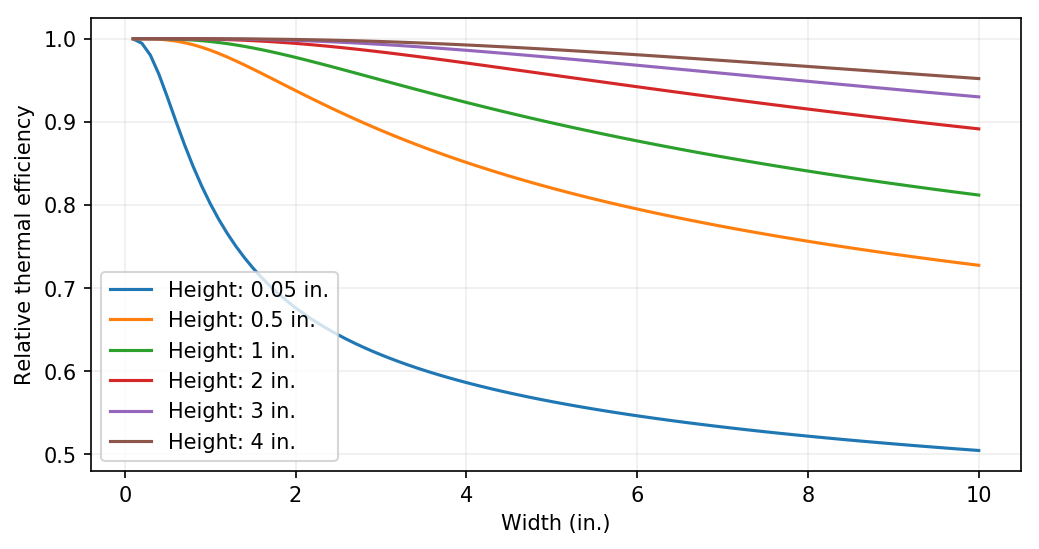

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=150)
for h,d in zip(heights,dat):
    plt.plot(wide, d, label=f"Height: {h} in.")
plt.legend()
plt.grid(True, alpha=0.2)
plt.xlabel("Width (in.)")
plt.ylabel("Relative thermal efficiency")
plt.show()

Expected baffle area: 2.50, actual baffle area: 2.58, difference: 3.20%
Expected baffle width: 1.0 inches, actual baffle width: 0.98, difference: -1.65%
Relative thermal efficiency: 99.97% 

Expected baffle area: 5.00, actual baffle area: 5.58, difference: 11.66%
Expected baffle width: 2.0 inches, actual baffle width: 1.90, difference: -5.07%
Relative thermal efficiency: 99.67% 

Expected baffle area: 7.50, actual baffle area: 9.26, difference: 23.40%
Expected baffle width: 3.0 inches, actual baffle width: 2.75, difference: -8.47%
Relative thermal efficiency: 98.98% 

Expected baffle area: 10.00, actual baffle area: 13.71, difference: 37.08%
Expected baffle width: 4.0 inches, actual baffle width: 3.55, difference: -11.32%
Relative thermal efficiency: 98.02% 

Expected baffle area: 12.50, actual baffle area: 18.99, difference: 51.95%
Expected baffle width: 5.0 inches, actual baffle width: 4.32, difference: -13.62%
Relative thermal efficiency: 96.91% 

Expected baffle area: 15.00, actual

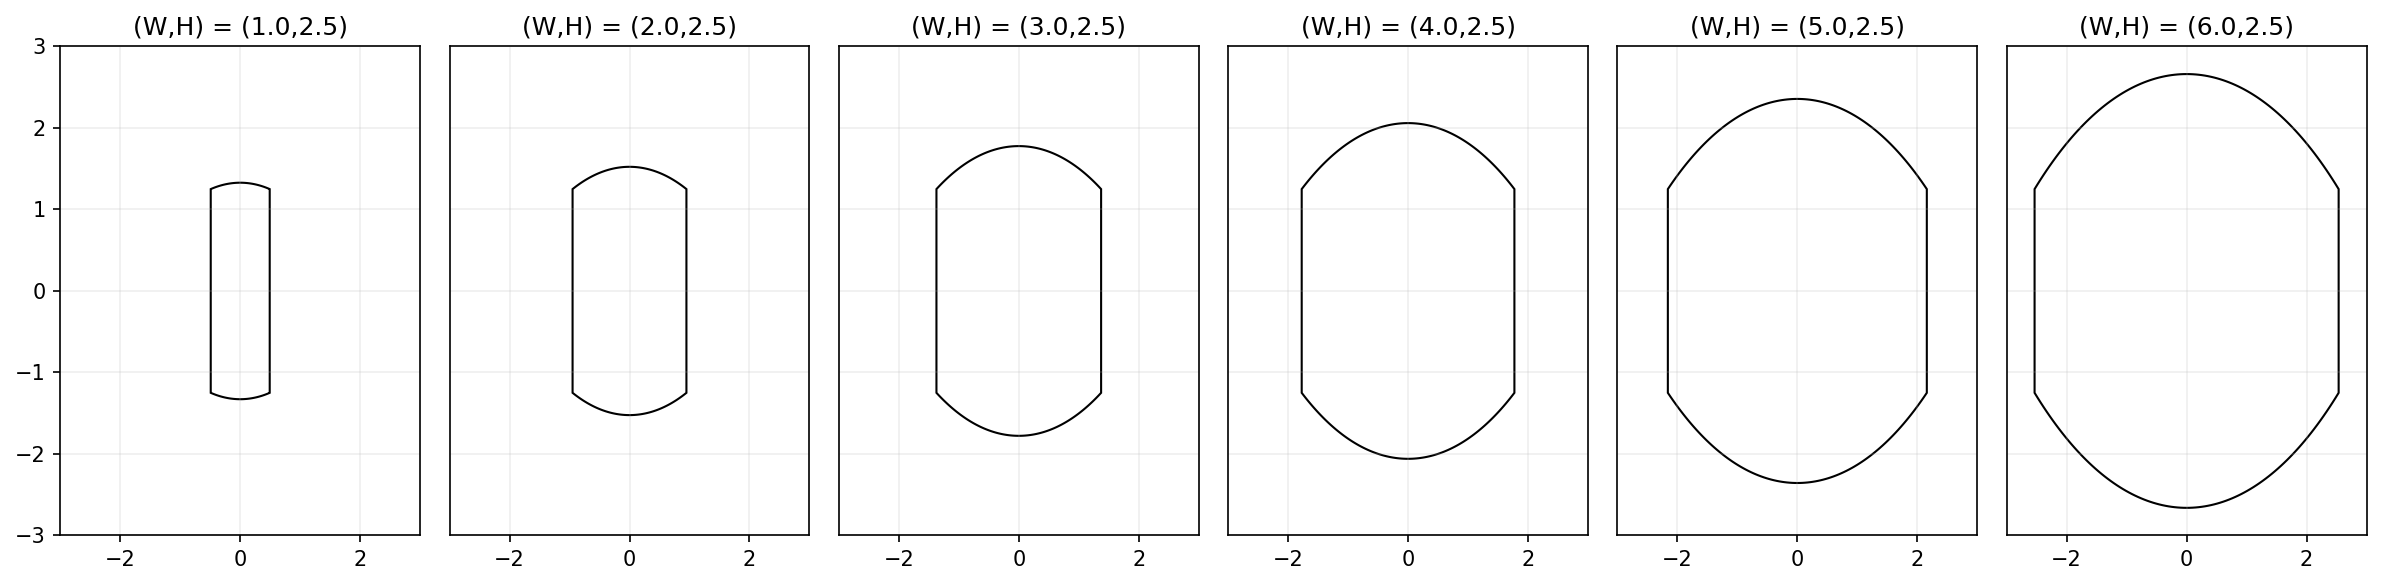

In [7]:
W = 5
H = 2.5
n_plots = 6
fig, ax = plt.subplots(1, n_plots, figsize=(16, 4), dpi=150, sharey=True)
Ws = np.linspace(W-4, W+1, n_plots)
for i, w in enumerate(Ws):
    ax[i].add_patch(plot_baffle(w, H))
    a = opt_a(w, H)
    area = rect_baffle_area(a, w, H)[0]
    x0 = catenary_x0(a, w)[0]
    print(f"Expected baffle area: {(w*H):.2f}, actual baffle area: {area:.2f}, difference: {((area-w*H)/(w*H)*100):.2f}%")
    print(f"Expected baffle width: {w} inches, actual baffle width: {(2*x0):.2f}, difference: {((2*x0-w)/w*100):.2f}%")
    print(f"Relative thermal efficiency: {(relative_efficiency(w, H)*100):.2f}% \n")
    lim = 3
    ax[i].set_xlim([-lim, lim])
    ax[i].set_ylim([-lim, lim])
    ax[i].set_title(f"(W,H) = ({w},{H})")
    ax[i].grid(True, alpha=0.2)
    if i>0:
        ax[i].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off
        
plt.tight_layout()
plt.show()

In [8]:
print(baffle_height(0, W, H),baffle_width(W, H))

4.71333704033 4.31880214954


In [102]:
import numba
import datetime

W = 2
H = .05

baff_w = baffle_width(W, H)
baff_h = baffle_height(0, W, H)

dw = baff_w/1023
dh = baff_h/1013
dt = 1

sim_w = baff_w
sim_h = baff_h + 2*5*dh

## Determine where the non-baffle fixed-temperature regions are
# build grid with real coordinates
wvalues = np.arange(-sim_w/2, sim_w/2+dw, dw)
hvalues = np.arange(-sim_h/2, sim_h/2+dh, dh)

Wlen = len(wvalues)
Hlen = len(hvalues)

ww, hh = np.meshgrid(wvalues, hvalues)
# create upper and lower mask
def in_baffle_y(x, y, W, H):
    a = opt_a(W, H)
    top = -catenary(a, x) + catenary_y_off(a, W) + a + H/2
    return(np.logical_and(y<top, y>-top))

def above_baffle(x, y, W, H):
    a = opt_a(W, H)
    top = -catenary(a, x) + catenary_y_off(a, W) + a + H/2
    return(y>top)

def below_baffle(x, y, W, H):
    a = opt_a(W, H)
    top = -catenary(a, x) + catenary_y_off(a, W) + a + H/2
    return(y<-top)

baffle_mask = (in_baffle_y(wvalues[:,None], hvalues[None,:], W, H)).T
above_mask = (above_baffle(wvalues[:,None], hvalues[None,:], W, H)).T
below_mask = (below_baffle(wvalues[:,None], hvalues[None,:], W, H)).T

## func for setting non-baffle temps
@numba.jit(nopython=True)
def impose_BC(grid, mask, temp):
    temp = np.ones(grid.shape)*temp
    grid = np.where(mask, temp, grid)
    return grid
    
Tunder = 36
Tover = 0
    
grid = np.zeros([Wlen,Hlen]).T           # matrix
grid = impose_BC(grid, above_mask, Tover)
grid = impose_BC(grid, below_mask, Tunder)

# Build MM, a list of matrices, each element corresponding to M at a given step
T = np.arange(0, 10000, dt)

@numba.jit(nopython=True)
def compute_error(old, new):             
    v = (new - old).flatten()
    return np.sqrt(np.dot(v,v))

@numba.jit(nopython=True)
def laplace_loop(grid , Wlen, Hlen, below_mask, above_mask, temps, err_lim=1E-16, step_lim=0, k=1):
    T_under, T_over = temps
    old_grid = np.zeros(grid.shape)
    err = []
    err.append(1)
    steps = 0
    while err[steps] > err_lim:
        for j in range(0, Wlen):
            for i in range(1, Hlen-1):
                grid[i,j] = k*(grid[i-1,j] + grid[i+1,j] + 
                               grid[i,(j-1)%Wlen] + grid[i,(j+1)%Wlen])/4

        # Re-assert heaters
        grid = impose_BC(grid, above_mask, T_over)
        grid = impose_BC(grid, below_mask, T_under)
        
        err.append(compute_error(old_grid, grid))
        old_grid = grid
        steps += 1
        
        if steps > step_lim and step_lim > 0:
            break

    return grid, err, steps

def baffle_init_temp_dist(L, H, T_lower, T_upper):
    a = opt_a(L, H)
    x0 = catenary_x0(a, L)[0]
    def top(x):
         return(-catenary(a, x) + catenary_y_off(a, L) + a + H/2)
    def bottom(x):
        return(-1*top(x))
    
    def interpolate(x, y):
        x0 = bottom(x)
        x1 = top(x)
        y0 = T_lower
        y1 = T_upper
        return(y0 + (y-x0)*(y1-y0)/(x1-x0))
    return interpolate

def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [103]:
t = datetime.datetime.now()
int_fun = baffle_init_temp_dist(W, H, Tunder, Tover)
grid = int_fun(wvalues[:,None], hvalues[None,:])
grid = impose_BC(grid, above_mask.T, Tover)
grid = impose_BC(grid, below_mask.T, Tunder)
grid, err, steps = laplace_loop(grid.T, Wlen, Hlen, below_mask.astype('float'), above_mask.astype('float'), [36, 0], step_lim=10000, k=1)
print(f"time: {str(datetime.datetime.now()-t)} seconds, err: {err[-1]:.2f}, steps: {steps}")

time: 0:06:23.097078 seconds, err: 4.00, steps: 10001


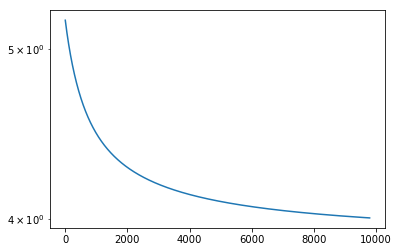

In [104]:
plt.semilogy(err[200:])
plt.show()

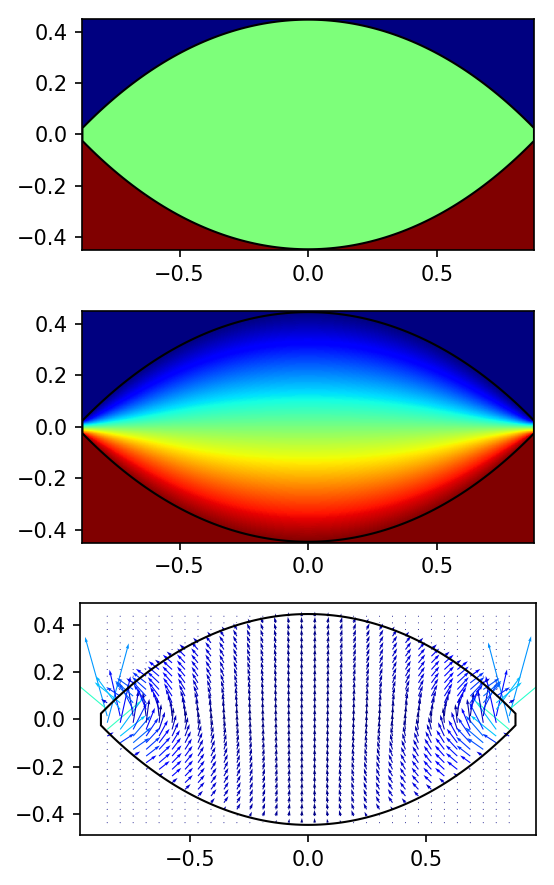

In [108]:
import functools

fig, ax = plt.subplots(3, 1, figsize=(14,6), dpi=150)
plt.set_cmap('jet')

pcm = ax[0].pcolormesh(ww, hh, above_mask*-1+below_mask)
ax[0].add_patch(plot_baffle(W, H))
ax[0].set_aspect('equal', 'box')
ax[0].set_title('')
#fig.colorbar(pcm, ax=ax[0])

pcm = ax[1].pcolormesh(ww, hh, grid)
ax[1].add_patch(plot_baffle(W, H))
ax[1].set_aspect('equal', 'box')
#fig.colorbar(pcm, ax=ax[1])

U, V = np.gradient(-grid)
ax[2].add_patch(plot_baffle(W, H))

reduce_factor = 30
wrap_rebin = functools.partial(rebin, new_shape=(32, 32))

qui = ax[2].quiver(wrap_rebin(ww), 
             wrap_rebin(hh), 
             wrap_rebin(V), 
             wrap_rebin(U), 
             np.power((wrap_rebin(V)**2,
                       wrap_rebin(U)**2),.5))
ax[2].set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

## Linear Interp Laplace

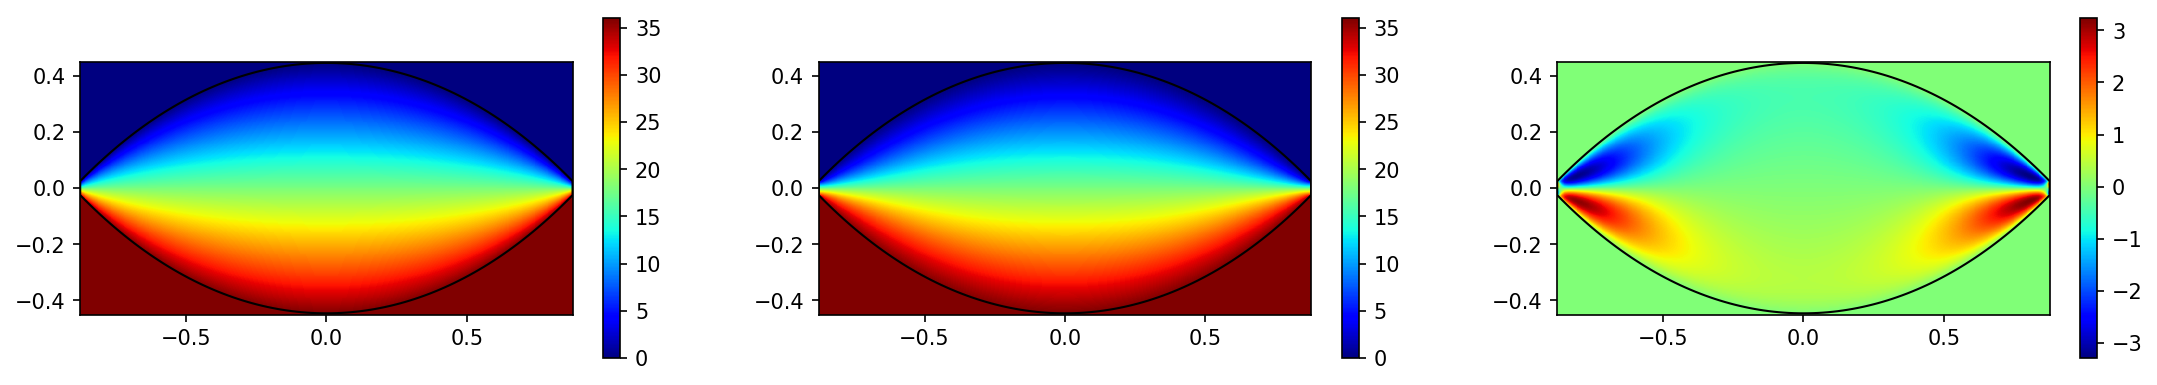

In [109]:
int_fun = baffle_temp_dist(W, H, Tunder, Tover)
arr = int_fun(wvalues[:,None], hvalues[None,:])
arr = impose_BC(arr, above_mask.T, Tover)
arr = impose_BC(arr, below_mask.T, Tunder)

fig, ax = plt.subplots(1, 3, figsize=(18,3), dpi=150)
pcm = ax[0].pcolormesh(ww, hh, arr.T)
ax[0].add_patch(plot_baffle(W, H))
ax[0].set_aspect('equal', 'box')
fig.colorbar(pcm, ax=ax[0])

pcm = ax[1].pcolormesh(ww, hh, grid)
ax[1].add_patch(plot_baffle(W, H))
ax[1].set_aspect('equal', 'box')
fig.colorbar(pcm, ax=ax[1])

pcm = ax[2].pcolormesh(ww, hh, grid-arr.T)
ax[2].add_patch(plot_baffle(W, H))
ax[2].set_aspect('equal', 'box')
fig.colorbar(pcm, ax=ax[2])
plt.show()

It turns out that a catenary is not quite the right functional form for a baffle wall. An arc of a circle is much more accurate. I think an arc of a circle may also be exactly solvable, so that's cool. I want the area of an arc segment (the area between the line that connects the endpoint of the arc and the segment of the circle) as a function of the length of the arc and the length of the line segment. We'll call the area $A$ the lenght of the arc $L$ and the length of the line $w$. We'll additionally call the length from the center of the line to the highest point of the curve $h$. Therefore, I am looking for $A(w,L)$. From the wikipedia page on an [arc](https://en.wikipedia.org/wiki/Arc_(geometry)):

$$A(r,\theta)=\frac{1}{2}r^2(\theta-\sin\theta)$$
$$L(r,\theta)=r\theta$$
$$r(w,h)=\frac{w^2}{8h} + \frac{h}{2}$$

From a the wikipedia page on a [chord](https://en.wikipedia.org/wiki/Chord_(geometry)):

$$w(r,\theta)=2r\sin\bigg(\frac{\theta}{2}\bigg)$$

From these, I think I can express $A(w,L)$.

First, rearranging the equation for $w$ to solve for $\theta$:

$$\theta = 2\arcsin\bigg( \frac{w}{2r} \bigg)$$

And I want to say that I can calculate $h$ from $L$ and $w$, but I don't immediately see how to do it.

$$L=2r\arcsin\bigg(\frac{w}{2r}\bigg)$$
$$\sin\bigg(\frac{L}{2r}\bigg)=\frac{w}{2r}$$

This is a transcendental equation, and a closed form solution is not possible. Instead, we can solve for $A(r,L)$:

$$\theta=\frac{L}{r}$$
$$A(r,L)=\frac{1}{2}r^2\bigg(\frac{L}{r}-\sin\bigg(\frac{L}{r}\bigg)\bigg)$$
$$w(r,L)=2r\sin\bigg( \frac{L}{2r} \bigg)$$

$$A_{baffle}(L,r)=\bigg[ r^2\bigg( \frac{L}{r} - \sin\bigg(\frac{L}{r}\bigg) \bigg) + 2Lr\sin\bigg(\frac{L}{2r}\bigg) \bigg]$$
$$r_{max}(L)=\text{argmax}_r[ A_{baffle}(L,r)]$$
$$A_{max}(L)=A_{baffle}(r_{max},L)$$
$$w_{max}(L)=w\bigg(r_{max},\frac{L}{r_{max}}\bigg)$$

What is the height above a chord? If the angle that chord subtends is $\theta$, and is symmetric about the $y$-axis, or $\pi/2$, then the angular range the chord extends over is 

$$\bigg[\frac{\pi}{2}-\frac{\theta}{2}, \frac{\pi}{2}+\frac{\theta}{2}\bigg]$$

The hieght from the $x$-axis of the center of the chord is then $h_{diff}=r\sin(\frac{\pi}{2}-\frac{\theta}{2})=r\cos(\frac{\theta}{2})$. The height of the arc above the chord is then

$$h(x) = \sqrt{r^2-x^2}-r\cos\bigg( \frac{L}{2r} \bigg)$$

over the domain of x is transformed by $x = r\cos\phi$. The domain is then:

$$\bigg[ -r\sin\frac{L}{2r}, r\sin\frac{L}{2r} \bigg]$$

or:

$$[-w/2, w/2]$$

In [35]:
class parent:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    @property
    def prod(self):
        pass
    
    def func(self):
        return self.r*self.a
        
class child(parent):
    def __init__(self, *args, **kwargs):
        self._say()
        self.r = 10
        super().__init__(*args, **kwargs)
    def _say(self):
        print('hi')
    

In [36]:
t = child(a=5,b=7)

hi


In [37]:
t.a

5

In [38]:
t.b

7

In [39]:
t.func()

50